In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="MIG-25a8cdbf-56c0-521b-b855-e8cd1f848fa1" 
from hydra.utils import instantiate
import yaml
import torch
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
device = "cuda:0"

# Load data and models

In [2]:
os.chdir('/allen/aics/modeling/ritvik/projects/benchmarking_representations/')
save_path = './test_pcna_embeddings/'

In [3]:
from br.data.get_datamodules import get_data
from cyto_dl.models.utils.mlflow import load_model_from_checkpoint
from br.models.load_models import load_model_from_path
from br.models.save_embeddings import get_pc_loss

def get_data_and_models(dataset_name, batch_size, results_path, debug=False):
    data_list = get_data(dataset_name, batch_size, results_path, debug)
    all_models, run_names, model_sizes = load_model_from_path(dataset_name, results_path) # default list of models in load_models.py
    return data_list, all_models, run_names, model_sizes

In [7]:
dataset_name = 'pcna'
batch_size = 2
debug=False
results_path = '/allen/aics/modeling/ritvik/projects/benchmarking_representations/configs/results/'
data_list, all_models, run_names, model_sizes = get_data_and_models(dataset_name, batch_size, results_path, debug)

In [21]:
gg = pd.DataFrame()
gg['model'] = run_names
gg['model_size'] = model_sizes
gg.to_csv(save_path + 'model_sizes.csv')

# Compute embeddings and emissions

In [9]:
from br.models.save_embeddings import save_embeddings

splits_list = ["train", 'val', "test"]
meta_key = None
eval_scaled_img = [False] * 5
eval_scaled_img_params = [{}] * 5
loss_eval_list = None
sample_points_list = [False, False, True, True, False]
skew_scale = 100
save_embeddings(
    save_path,
    data_list,
    all_models,
    run_names,
    debug,
    splits_list,
    device,
    meta_key,
    loss_eval_list,
    sample_points_list,
    skew_scale,
    eval_scaled_img,
    eval_scaled_img_params,
)

Processing train


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1089/1089 [00:52<00:00, 20.87it/s]


Processing val


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.67it/s]


Processing test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 20.52it/s]


Processing train


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1089/1089 [00:57<00:00, 18.99it/s]


Processing val


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 10.83it/s]


Processing test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:03<00:00, 18.36it/s]


Processing train


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1089/1089 [03:32<00:00,  5.12it/s]


Processing val


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.85it/s]


Processing test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:15<00:00,  4.03it/s]


Processing train


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1089/1089 [07:29<00:00,  2.42it/s]


Processing val


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


Processing test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:28<00:00,  2.15it/s]


Processing train


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1089/1089 [00:56<00:00, 19.22it/s]


Processing val


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.95it/s]


Processing test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:03<00:00, 18.81it/s]


In [10]:
from br.models.save_embeddings import save_emissions

max_batches = 2
save_emissions(
    save_path,
    data_list,
    all_models,
    run_names,
    max_batches,
    debug,
    device,
    loss_eval_list,
    sample_points_list,
    skew_scale,
    eval_scaled_img,
    eval_scaled_img_params,
)

  3%|███▋                                                                                                             | 2/61 [00:04<02:23,  2.44s/it]


In [11]:
run_names

['Classical_pointcloud',
 'SO3_pointcloud',
 'Classical_image',
 'SO3_image',
 'SO3_pointcloud_jitter']

In [18]:
df['flag_comment'].value_counts()

no comment                             2344
bad segmentation of PCNA                 57
no EGFP fluorescence                     13
cell appears dead or dying                3
bad segmentation of cell or nucleus       3
Name: flag_comment, dtype: int64

# Compute benchmarking features

In [19]:
from br.models.compute_features import compute_features
from br.models.save_embeddings import get_pc_loss_chamfer
from br.models.utils import get_all_configs_per_dataset

keys = ['pcloud', 'pcloud', 'image', 'image', 'pcloud']
max_embed_dim = 256
DATA_LIST = get_all_configs_per_dataset(results_path)
data_config_list = DATA_LIST[dataset_name]["data_paths"]

evolve_params = {
    "modality_list_evolve": keys,
    "config_list_evolve": data_config_list,
    "num_evolve_samples": 40,
    "compute_evolve_dataloaders": False,
    "eval_meshed_img": [False] * 5,
    "skew_scale": 100,
    "eval_meshed_img_model_type": [None] * 5,
    "only_embedding": False,
    "fit_pca": False,
}

loss_eval = get_pc_loss_chamfer()
loss_eval_list = [loss_eval] * 5
use_sample_points_list = [False, False, True, True, False]

classification_params = {"class_labels": ["cell_stage_fine", 'flag_comment']}
rot_inv_params = {"squeeze_2d": False, "id": "cell_id"}

regression_params = {"df_feat": None, "target_cols": None, "feature_df_path": None}

compactness_params = {
    "method": "mle",
    "num_PCs": None,
    "blobby_outlier_max_cc": None,
    "check_duplicates": True,
}

splits_list = ["train", "val", "test"]
compute_embeds = False

metric_list = [
    # "Rotation Invariance Error",
    # "Evolution Energy",
    # "Reconstruction",
    "Classification",
    # "Compactness",
]


compute_features(
    dataset=dataset_name,
    results_path=results_path,
    embeddings_path=save_path,
    save_folder=save_path,
    data_list=data_list,
    all_models=all_models,
    run_names=run_names,
    use_sample_points_list=use_sample_points_list,
    keys=keys,
    device=device,
    max_embed_dim=max_embed_dim,
    splits_list=splits_list,
    compute_embeds=compute_embeds,
    classification_params=classification_params,
    regression_params=regression_params,
    metric_list=metric_list,
    loss_eval_list=loss_eval_list,
    evolve_params=evolve_params,
    rot_inv_params=rot_inv_params,
    compactness_params=compactness_params,
)

Computing classification


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


In [13]:
run_names

['Classical_pointcloud',
 'SO3_pointcloud',
 'Classical_image',
 'SO3_image',
 'SO3_pointcloud_jitter']

# Polar plot viz

In [25]:
from br.features.plot import collect_outputs
from br.features.plot import plot

model_order = ["Classical_image", "SO3_image", "Classical_pointcloud", "SO3_pointcloud"]
metric_list = ['reconstruction', 'emissions', 'classification_cell_stage_fine', 'classification_flag_comment',
               'compactness', 'evolution_energy', 
               'model_sizes', 'rotation_invariance_error']
norm = 'std'
title = 'pcna_comparison'
colors_list = None
unique_expressivity_metrics = ['Classification_cell_stage_fine', 'Classification_flag_comment']
df, df_non_agg = collect_outputs(save_path, norm, model_order, metric_list)
plot(save_path, df, model_order, title, colors_list, norm, unique_expressivity_metrics)

reconstruction
emissions
classification_cell_stage_fine
classification_flag_comment
compactness
evolution_energy
model_sizes
rotation_invariance_error


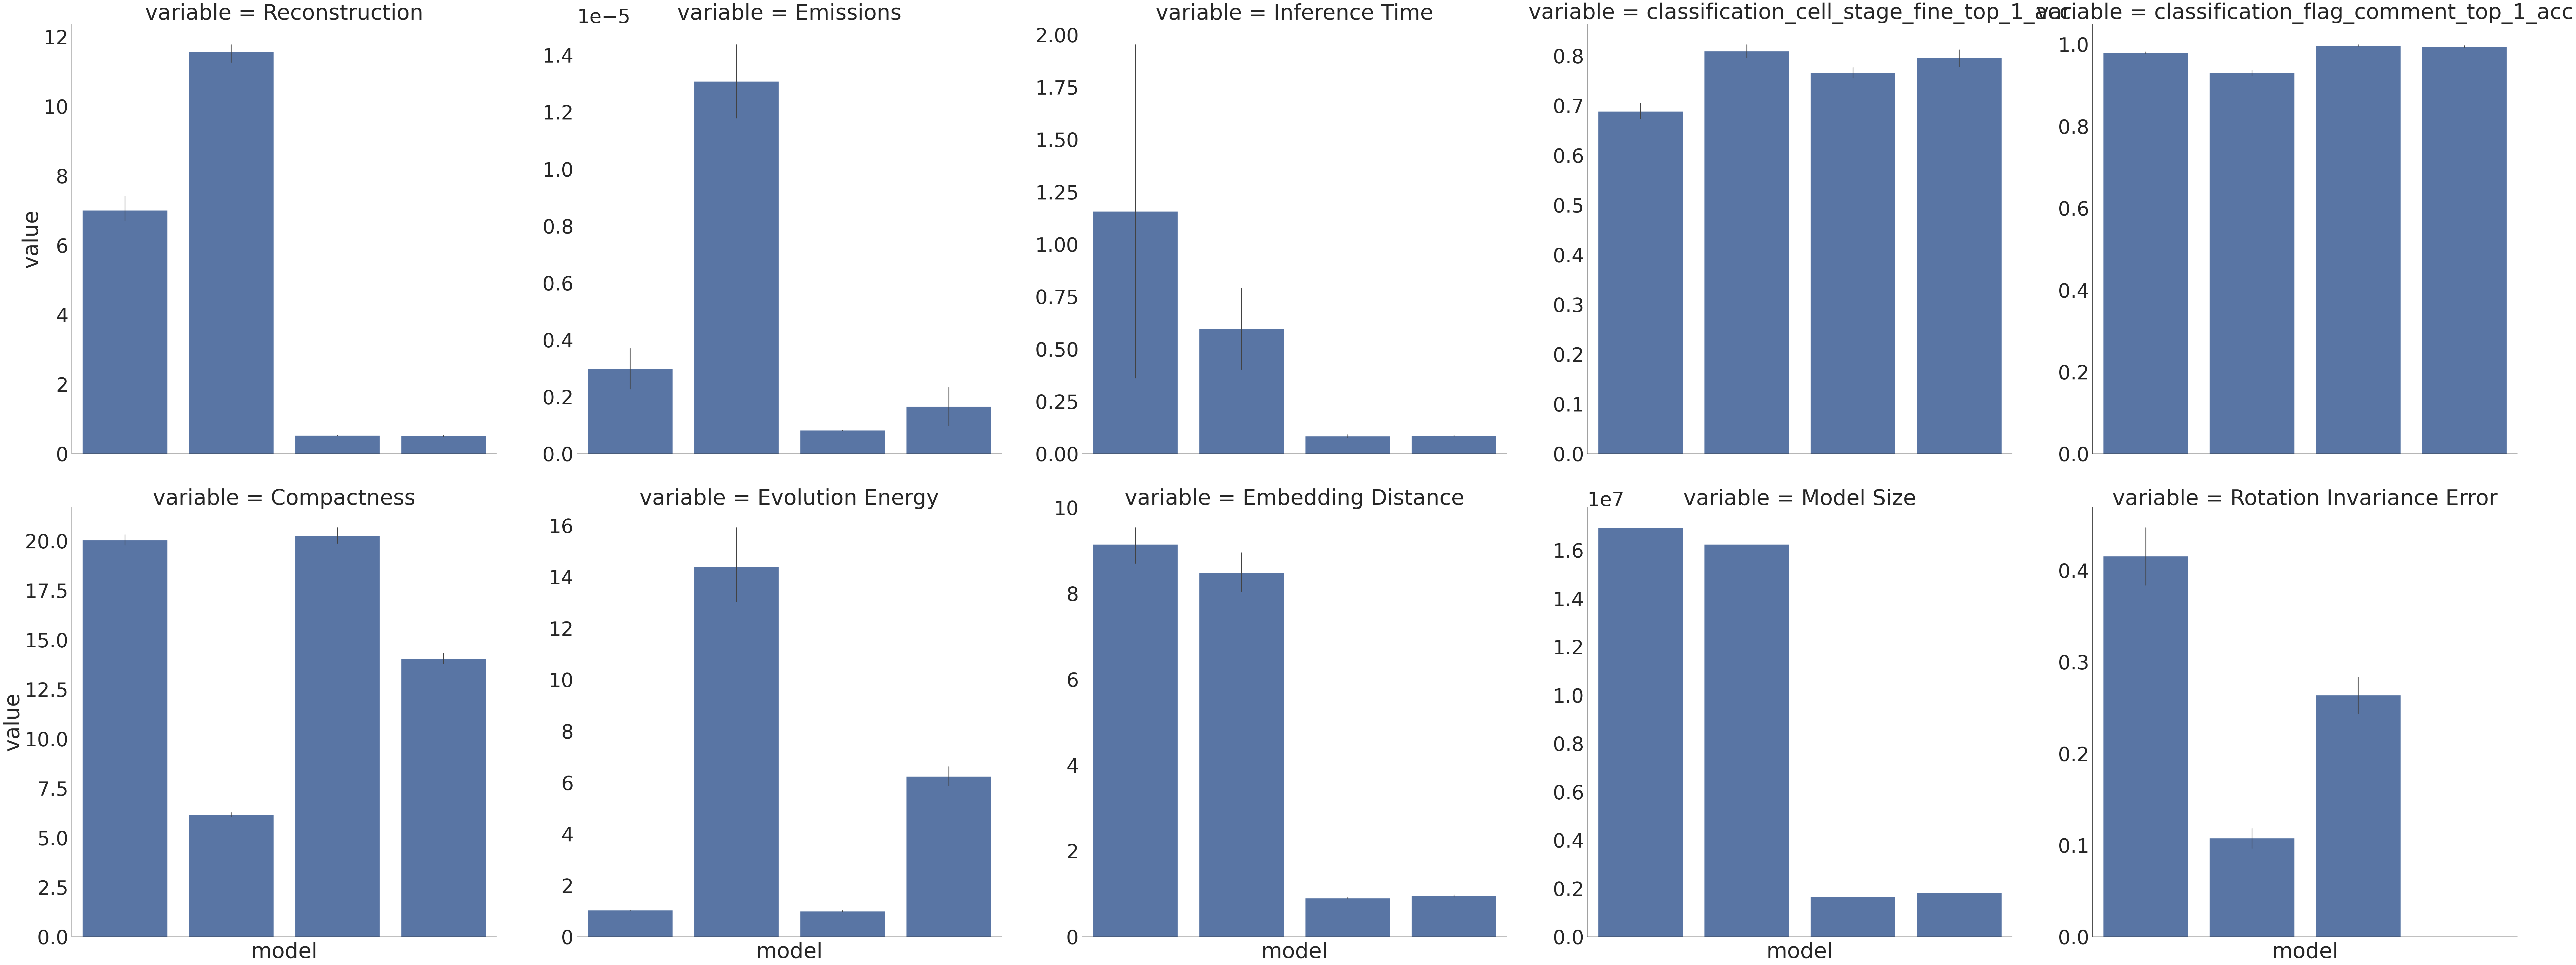

In [51]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale=5)  
sns.set_style('white')
g = sns.catplot(data=df_non_agg, x='model', y='value', col='variable', kind='bar', 
            sharey=False, sharex=True, order=model_order, col_wrap=5, height=20, aspect=1)
g.set_xticklabels(rotation=30)

In [26]:
df_non_agg

,model,variable,value,index
0,Classical_image,Reconstruction,6.709610,NaN
1,Classical_image,Reconstruction,6.906844,NaN
2,Classical_image,Reconstruction,7.422655,NaN
3,Classical_pointcloud,Reconstruction,0.539547,NaN
4,Classical_pointcloud,Reconstruction,0.528920,NaN
...,...,...,...,...
6820,SO3_pointcloud_jitter,Rotation Invariance Error,0.000116,1215.0
6821,SO3_pointcloud_jitter,Rotation Invariance Error,0.000000,1216.0
6822,SO3_pointcloud_jitter,Rotation Invariance Error,0.000235,1217.0
6823,SO3_pointcloud_jitter,Rotation Invariance Error,0.000000,1218.0
